<h1 align=center><font size="5"> SVM (Support Vector Machines)</font></h1>

В этой записной книжке вы будете использовать SVM (машины опорных векторов) для построения и обучения модели с использованием данных о человеческих клетках и классификации клеток по тому, являются ли они доброкачественными или злокачественными.

SVM работает путем сопоставления данных с пространством объектов, так что точки данных могут быть классифицированы, даже если данные не являются линейно разделяемыми. Чтобы найти разделитель между категориями, данные преобразуются таким образом, что разделитель можно нарисовать как гиперплоскость. После этого характеристики новых данных могут использоваться для прогнозирования группы, к которой должна принадлежать новая запись данных.

In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

Пример основан на наборе данных, который является общедоступным из репозитория машинного обучения [http://mlearn.ics.uci.edu/MLRepository.html]. Набор данных состоит из нескольких сотен записей образцов клеток человека, каждая из которых содержит значения набора характеристик клеток.

### Загрузим данные из файла CSV 

In [3]:
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head()

ID  Clump  UnifSize  UnifShape  MargAdh  SingEpiSize BareNuc  \
0  1000025      5         1          1        1            2       1   
1  1002945      5         4          4        5            7      10   
2  1015425      3         1          1        1            2       2   
3  1016277      6         8          8        1            3       4   
4  1017023      4         1          1        3            2       1   

   BlandChrom  NormNucl  Mit  Class  
0           3         1    1      2  
1           3         2    1      2  
2           3         1    1      2  
3           3         7    1      2  
4           3         1    1      2

Поле идентификатора ID содержит идентификатор пациента. Характеристики образцов клеток каждого пациента содержатся в полях Clump - Mit. Значения оцениваются от 1 до 10, причем 1 является наиболее близким к доброкачественной клетке.

Поле Class содержит диагноз, подтвержденный отдельными медицинскими процедурами, относительно того, являются ли образцы доброкачественными (значение = 2) или злокачественными (значение = 4).

Давайте посмотрим на распределение классов на основе толщины и размера клетки:

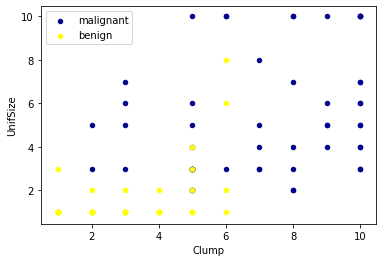

In [4]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

## Предварительная обработка и выборка данных

Давайте сначала посмотрим на типы данных:

In [5]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

Похоже, что столбец __BareNuc__ содержит некоторые значения, которые не являются числовыми. Мы можем отбросить эти строки:

In [6]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [7]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

Мы хотим, чтобы модель предсказывала значение класса (то есть, доброкачественного (= 2) или злокачественного (= 4)). Поскольку это поле может иметь только одно из двух возможных значений, нам нужно изменить уровень его измерения.

In [8]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

## Обучающий / Тестовый набор данных

Разобъем наш набор данных на обучающий и тестовый набор:

In [9]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


<h2 id="modeling">Моделирование (SVM с Scikit-Learn)</h2>

Алгоритм SVM предлагает выбор функций для выполнения обработки. По сути, отображение данных в пространство более высокой размерности называется kernelling. Математическая функция, используемая для преобразования, называется функцией ядра и может быть разных типов, например:

     1. Линейная
     2. Полином
     3. Радиальная базисная функция (RBF)
     4. Сигмовидная
     
Каждая из этих функций имеет свои характеристики, свои плюсы и минусы и свое уравнение, но поскольку нет простого способа узнать, какая функция работает лучше всего с любым данным набором данных, мы обычно выбираем разные функции по очереди и сравниваем результаты. Давайте просто используем по умолчанию RBF (Radial Basis Function) для этой лабораторной работы.

In [11]:
from sklearn import svm
clf = svm.SVC(kernel='rbf',gamma='auto')
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

После подгонки модель можно использовать для прогнозирования новых значений:

In [12]:
yhat = clf.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

<h2 id="evaluation">Оценка</h2>

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

   micro avg       0.96      0.96      0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


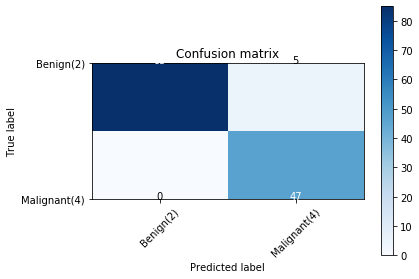

In [15]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

Вы также можете использовать библиотеку __f1_score__ из библиотеки sklearn:

In [18]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.9639038982104676

Давайте попробуем индекс jaccard для оценки точности:

In [19]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.9635036496350365

<h2 id="practice">Практика</h2>

Можете ли вы перестроить модель, но на этот раз с __linear__ ядром? Вы можете использовать опцию __kernel='linear'__, когда определяете svm. Как точность изменяется с новой функцией ядра?

In [ ]:
# write your code here


Дважды щелкните __здесь__ чтобы увидеть решение.

<!-- Your answer is below:
    
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat2))

-->